# Digit Recognition Using Keras

In [1]:
import warnings

warnings.filterwarnings('ignore')

## Dependencies

For faster training, if your system consists of an NVIDIA GPU, you can install **CUDA** and **CuDNN**.

In [ ]:
HAS_CUDA_CUDNN  = input('CUDA and CuDNN installed? (y/n): ') == 'y'

#### Keras Backend

In [ ]:
KERAS_BACKEND   = input('Keras Backend?: (theano / tensorflow): ')

In [ ]:
if KERAS_BACKEND == 'theano':
    KERAS_BACKEND = 'Theano'
else:
    if HAS_CUDA_CUDNN:
        KERAS_BACKEND = 'tensorflow-gpu'
    else:
        KERAS_BACKEND = 'tensorflow'

In [ ]:
DEPENDENCIES    = [
    'numpy',
    'scipy',
    'scikit-learn',
    'matplotlib',
    'keras',
    KERAS_BACKEND,
    'h5py',
    'cython'
]

import pip

for dependency in DEPENDENCIES:
    pip.main(['install', dependency])

## Visualization

In [2]:
import numpy as np

import matplotlib.pyplot as pplt
import matplotlib.cm     as cmap

pplt.style.use('seaborn')

% matplotlib inline

In [3]:
def plot(x):
    nsamples = len(x)
    nplots   = 4
    
    for i in range(nplots):
        pplt.subplot(220 + (i + 1))
        
        index  = np.random.randint(0, nsamples)
        sample = Xtrain[index]
        
        pplt.imshow(sample, cmap = cmap.gray)

## Preprocessing

### Flattening

In [4]:
def flatten(x, dtype = np.uint8):
    nsamples, width, height = x.shape
    ncols = width * height
    
    x     = x.reshape(nsamples, ncols).astype(dtype)
    
    return x

### Normalization

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
def normalize(x, *args, **kwargs):
    scaler = MinMaxScaler(*args, **kwargs)
    
    scaled = scaler.fit_transform(x)
    
    return scaled

### Encoding

In [7]:
from keras.utils import np_utils

Using TensorFlow backend.


In [8]:
def one_hot(x):
    encoded = np_utils.to_categorical(x)
    
    return encoded

## Modelling

In [9]:
from keras.models import Sequential
from keras.layers import Dense

In [10]:
def get_layers(X, y, hidden):
    ninp   = X.shape[1]
    nout   = y.shape[1]
    
    layers = [ninp] + hidden + [nout]
    
    return layers

In [11]:
def get_model(layers, config):
    model = Sequential()
    
    model.add(Dense(layers[ 1], input_shape = (layers[0],), kernel_initializer = 'normal', activation = 'relu'))
    
    for i in range(2, len(layers) - 1):
        model.add(Dense(layers[i], activation = 'relu'))
        
    model.add(Dense(layers[-1], activation = 'softmax'))
    
    model.compile(**config)
    
    return model

## Training

In [12]:
def fit(model, Xtrain, ytrain, Xtest, ytest, *args, **kwargs):
    history = model.fit(Xtrain, ytrain, validation_data = (Xtest, ytest), *args, **kwargs)
    
    fig, axes = pplt.subplots(2)
    fig.set_size_inches(20, 15)
    
    axes[0].plot(history.history['acc'])
    axes[0].plot(history.history['val_acc'])
    axes[0].set_xlabel('$epoch$')
    axes[0].set_ylabel('$accuracy$')
    axes[0].legend(['$train$', '$test$'])
    
    axes[1].plot(history.history['acc'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_xlabel('$epoch$')
    axes[1].set_ylabel('$loss$')
    axes[1].legend(['$train$', '$test$'])
    
    return axes, model

## Deployment

In [13]:
import os, json, errno

RELPATH_DATA   = 'data'
RELPATH_MODELS = os.path.join(RELPATH_DATA, 'models')

def makedirs(path, ignore_exists = False):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno == errno.EEXIST:
            if not ignore_exists:
                raise e
        else:
            raise e
            
makedirs(RELPATH_MODELS, ignore_exists = True)

In [14]:
def save(dirname, model, config):
    RELPATH_DIR = os.path.join(RELPATH_MODELS, dirname)
    
    makedirs(RELPATH_DIR, ignore_exists = True)
    
    json_       = model.to_json()

    with open(os.path.join(RELPATH_DIR, 'model.json'), 'w') as f:
        f.write(json_)
        
    model.save_weights(os.path.join(RELPATH_DIR, 'model.h5'))
    
    with open(os.path.join(RELPATH_DIR, 'config.json'), 'w') as f:
        json.dump(config, f)

# MNIST
> English

### Loading

In [15]:
from keras.datasets import mnist

In [16]:
(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()

### Visualization

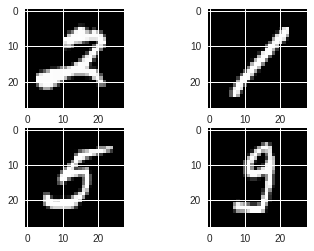

In [17]:
plot(Xtrain)

### Preprocessing

#### Flattening

In [18]:
Xtrain, Xtest = flatten(Xtrain), flatten(Xtest)

#### Normalization

In [19]:
Xtrain, Xtest = normalize(Xtrain), normalize(Xtest)

#### Encoding

In [20]:
ytrain, ytest = one_hot(ytrain), one_hot(ytest)

### Modelling

In [21]:
layers = get_layers(Xtrain, ytrain, [512, 512])
config = { "loss": "categorical_crossentropy", "optimizer": "adam", "metrics": ["accuracy"] }

In [22]:
model  = get_model(layers, config)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Training

In [23]:
batch_size  = 128
nepochs     = 20

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s - loss: 0.2160 - acc: 0.9362 - val_loss: 0.1225 - val_acc: 0.9603
Epoch 2/20
60000/60000 [==============================] - 3s - loss: 0.0787 - acc: 0.9756 - val_loss: 0.0816 - val_acc: 0.9744
Epoch 3/20
60000/60000 [==============================] - 3s - loss: 0.0490 - acc: 0.9847 - val_loss: 0.0662 - val_acc: 0.9795
Epoch 4/20
60000/60000 [==============================] - 3s - loss: 0.0349 - acc: 0.9883 - val_loss: 0.0699 - val_acc: 0.9789
Epoch 5/20
60000/60000 [==============================] - 3s - loss: 0.0262 - acc: 0.9914 - val_loss: 0.1033 - val_acc: 0.9727
Epoch 6/20
60000/60000 [==============================] - 3s - loss: 0.0206 - acc: 0.9935 - val_loss: 0.0828 - val_acc: 0.9774
Epoch 7/20
60000/60000 [==============================] - 3s - loss: 0.0156 - acc: 0.9949 - val_loss: 0.0828 - val_acc: 0.9792
Epoch 8/20
60000/60000 [==============================] - 3s 

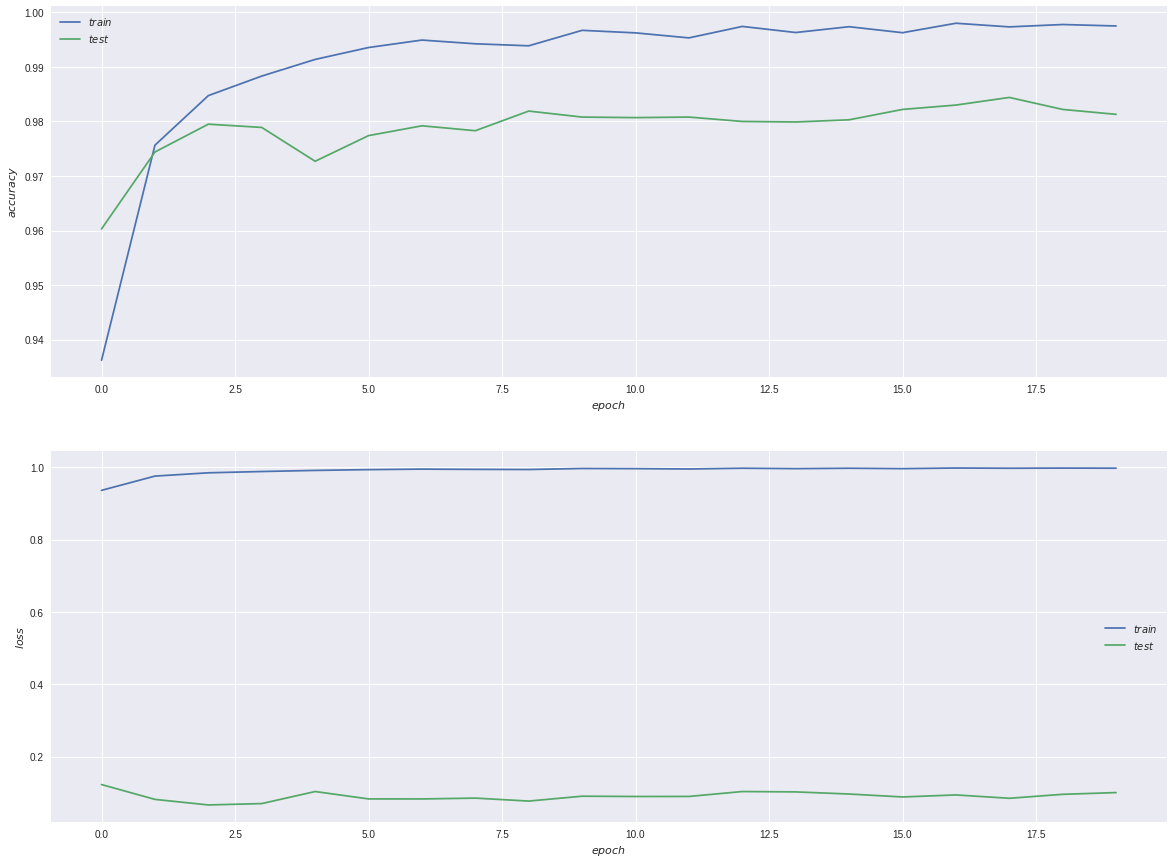

In [24]:
axes, model = fit(model, Xtrain, ytrain, Xtest, ytest, batch_size = batch_size, epochs = nepochs)

### Testing

In [25]:
score = model.evaluate(Xtest, ytest)

 9440/10000 [===========================>..] - ETA: 0s

In [26]:
print('Accuracy: ', score[1] * 100)

Accuracy:  98.13


### Deploy

In [27]:
save('mnist', model, config)